In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import model_selection
from sklearn.ensemble.forest import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn import  preprocessing
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_selection import SelectKBest, chi2, f_regression
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold


C:\Users\skdud\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
path = r'C:\Users\skdud\Loan_datasets'
test = pd.read_csv(path +  r'\test_lAUu6dG.csv')
train = pd.read_csv(path+r'\train_ctrUa4K.csv')
test_original = test.copy()
train_original = train.copy()

# y = train.Loan_Status
# X = train.drop(['Loan_ID','Loan_Status'],axis=1)


# Methods for this Competition

In [3]:
def fill_na(df):
    for i in df.columns:
        if df[i].dtype == 'object':
            df[i].fillna(df[i].mode()[0],inplace=True)
        else:
            df[i].fillna(df[i].median(),inplace=True)
    return df

def creating_new_features(df):
    df['Total_income'] = df['ApplicantIncome'] + df['CoapplicantIncome']
    df['Emi'] = round(df['LoanAmount']/df['Loan_Amount_Term']*1000,2)
    df['Dependents']=df['Dependents'].replace('3+',3)
    
    return df

def cat_to_num(df):
    for i in df.columns:
        if df[i].dtype == 'object':
            dummy = pd.get_dummies(df[i])
            df = pd.concat([df,dummy],axis=1)
    return df

#Plot function
def bar_plot_cat(list_of_features):
    plt.figure(1) 
    plt.subplot(221) 
    train[list_of_features[0]].value_counts(normalize=True).plot.bar(figsize=(20,10), title= list_of_features[0]) 
    plt.subplot(222) 
    train[list_of_features[1]].value_counts(normalize=True).plot.bar(title= list_of_features[1]) 
    plt.subplot(223) 
    train[list_of_features[2]].value_counts(normalize=True).plot.bar(title= list_of_features[2]) 
    plt.subplot(224) 
    train[list_of_features[3]].value_counts(normalize=True).plot.bar(title= list_of_features[3]) 
    plt.show()
    
def bi_variate_plots(feature):
    cross_tab=pd.crosstab(train[feature],train['Loan_Status']) 
    cross_tab.div(cross_tab.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True, figsize=(4,4))
    plt.show() 

In [4]:
train['Loan_Status'].value_counts()

Y    422
N    192
Name: Loan_Status, dtype: int64

In [5]:
train['Loan_Status'].value_counts(normalize=True)

Y    0.687296
N    0.312704
Name: Loan_Status, dtype: float64

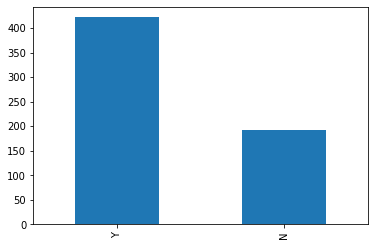

In [6]:
train['Loan_Status'].value_counts().plot.bar()

The loan of 422(around 69%) people out of 614 was approved.

Now lets visualize each variable separately. Different types of variables are Categorical, ordinal and numerical.

Categorical features: These features have categories (Gender, Married, Self_Employed, Credit_History, Loan_Status)
Ordinal features: Variables in categorical features having some order involved (Dependents, Education, Property_Area)
Numerical features: These features have numerical values (ApplicantIncome, CoapplicantIncome, LoanAmount, Loan_Amount_Term)
Let’s visualize the categorical and ordinal features first.

# Independent Variable (Categorical)


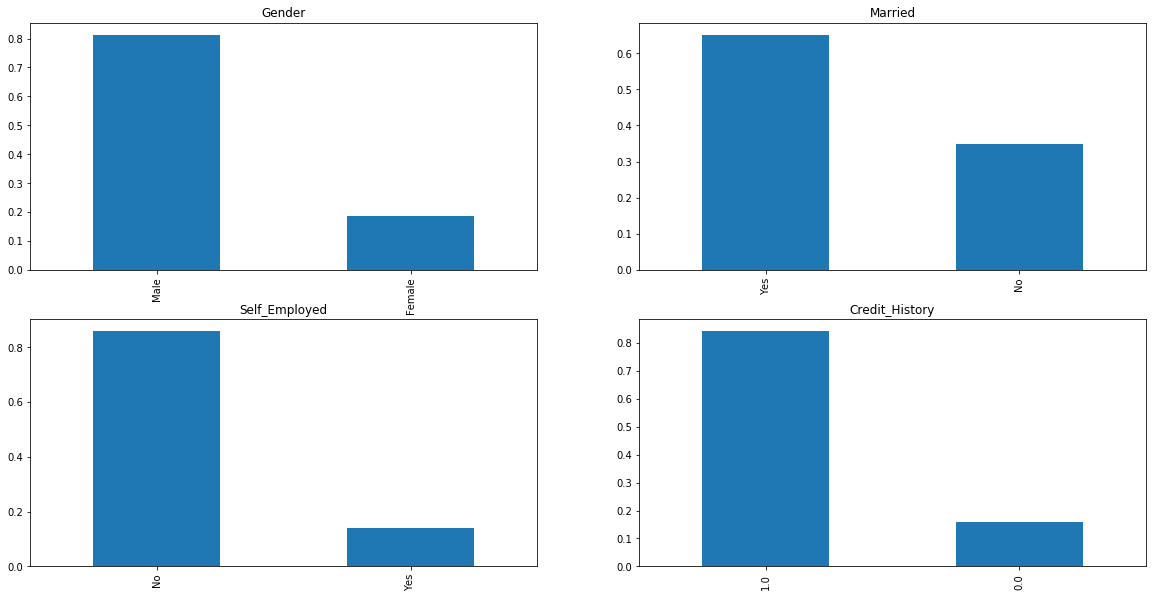

In [7]:
bar_plot_cat(['Gender','Married','Self_Employed','Credit_History'])

It can be inferred from the above bar plots that:

80% applicants in the dataset are male.
Around 65% of the applicants in the dataset are married.
Around 15% applicants in the dataset are self employed.
Around 85% applicants have repaid their debts.


# Now let’s visualize the ordinal variables.

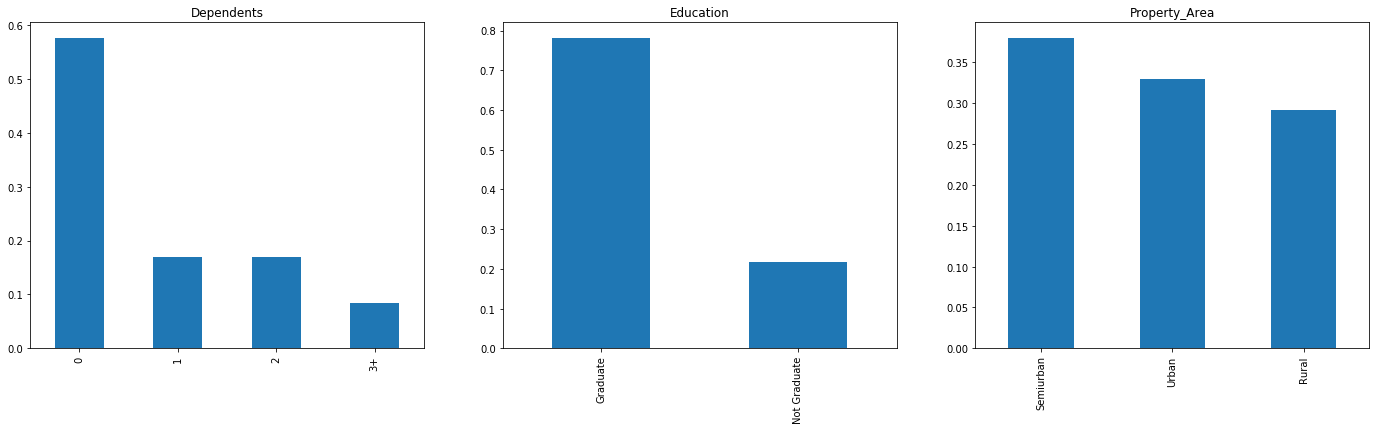

In [8]:
plt.figure(1) 
plt.subplot(131) 
train['Dependents'].value_counts(normalize=True).plot.bar(figsize=(24,6), title= 'Dependents') 
plt.subplot(132) 
train['Education'].value_counts(normalize=True).plot.bar(title= 'Education') 
plt.subplot(133) 
train['Property_Area'].value_counts(normalize=True).plot.bar(title= 'Property_Area') 
plt.show()

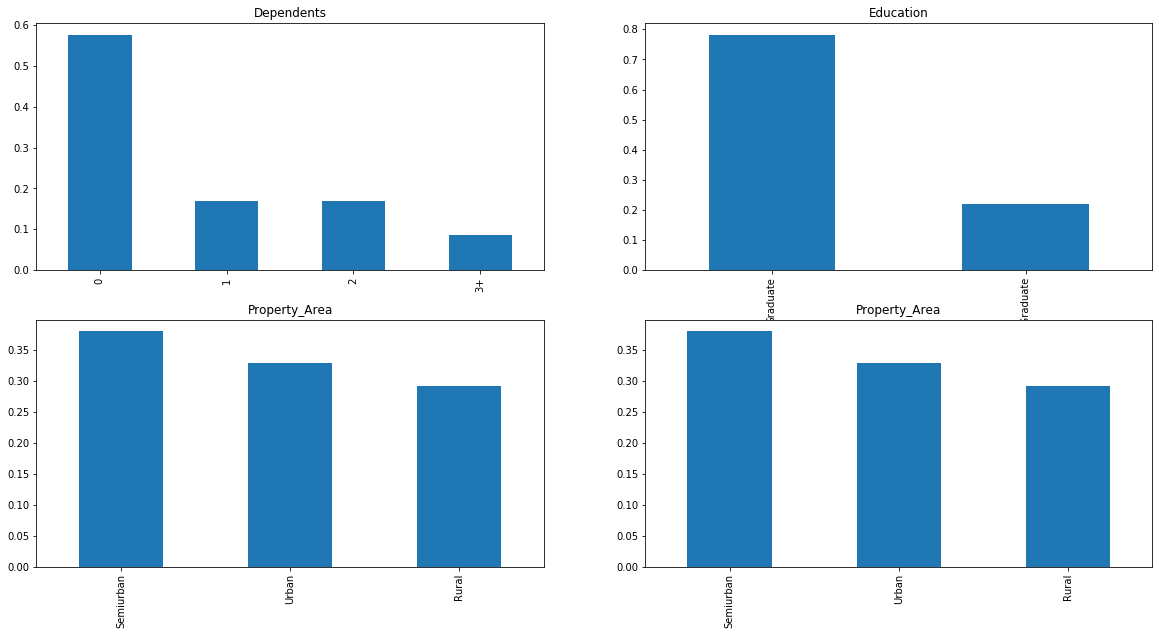

In [9]:
#Taking property area twice because this function will take 4 features so not a problem
bar_plot_cat(['Dependents','Education','Property_Area','Property_Area'])

Following inferences can be made from the above bar plots:

Most of the applicants don’t have any dependents.
Around 80% of the applicants are Graduate.
Most of the applicants are from Semiurban area.

# Independent Variable (Numerical)

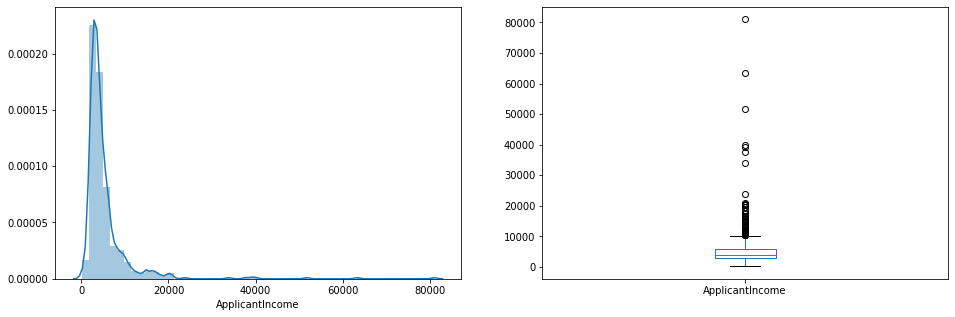

In [10]:
plt.figure(1) 
plt.subplot(121)
sns.distplot(train['ApplicantIncome']); 
plt.subplot(122) 
train['ApplicantIncome'].plot.box(figsize=(16,5)) 
plt.show()

Text(0.5, 0.98, '')

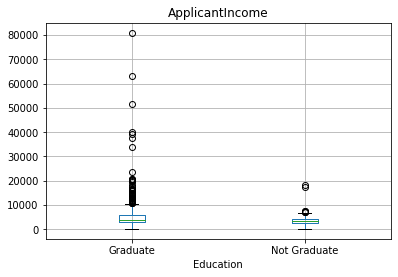

In [11]:
train.boxplot(column='ApplicantIncome', by = 'Education')
plt.suptitle("")

We can see that there are a higher number of graduates with very high incomes, which are appearing to be the outliers.

Let’s look at the Coapplicant income distribution.

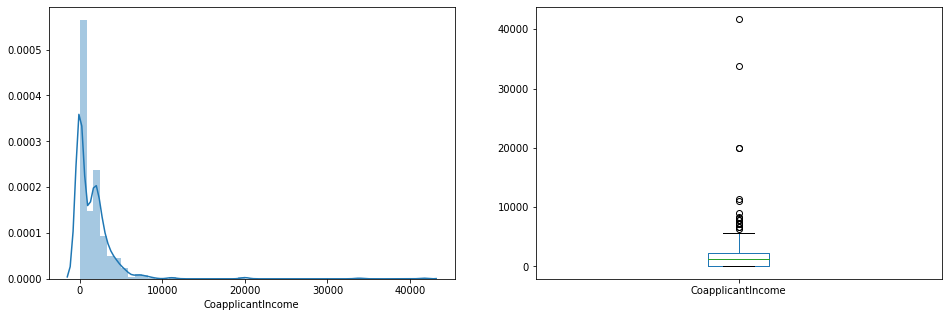

In [12]:
plt.figure(1)
plt.subplot(121) 
sns.distplot(train['CoapplicantIncome']); 
plt.subplot(122)
train['CoapplicantIncome'].plot.box(figsize=(16,5)) 
plt.show()


We see a similar distribution as that of the applicant income. 
Majority of coapplicant’s income ranges from 0 to 5000. 
We also see a lot of outliers in the coapplicant income and it is not normally distributed.

Let’s look at the distribution of LoanAmount variable.

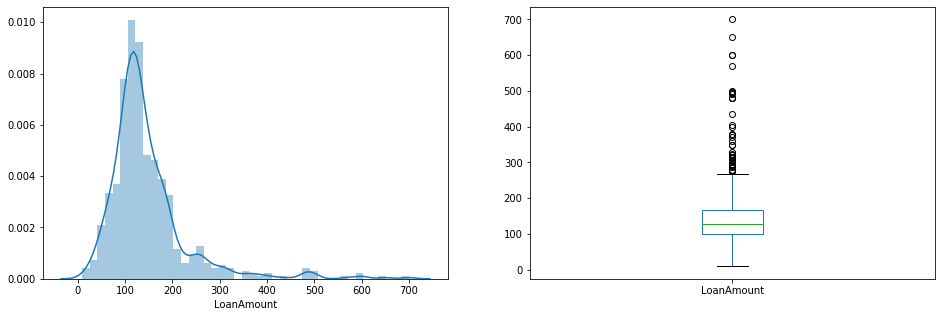

In [13]:
plt.figure(1) 
plt.subplot(121) 
df=train.dropna()
sns.distplot(train['LoanAmount']); 
plt.subplot(122) 
train['LoanAmount'].plot.box(figsize=(16,5)) 
plt.show()

We see a lot of outliers in this variable and the distribution is fairly normal.
We will treat the outliers later.

Now we would like to know how well each feature correlate with Loan Status

# Bivariate Analysis

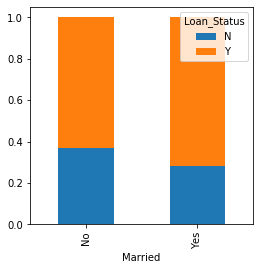

In [14]:
bi_variate_plots('Married')

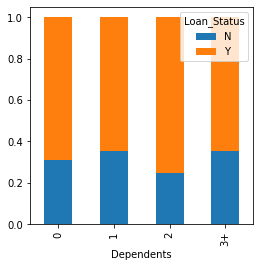

In [15]:
bi_variate_plots('Dependents')

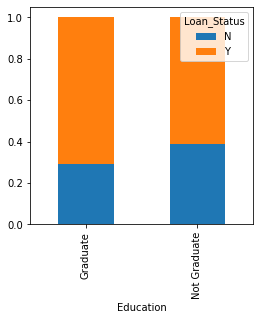

In [16]:
bi_variate_plots('Education')

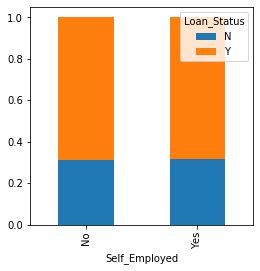

In [17]:
bi_variate_plots('Self_Employed')

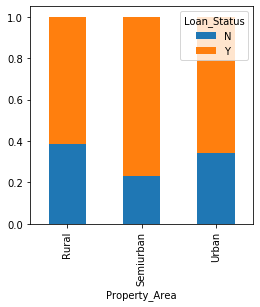

In [18]:
bi_variate_plots('Property_Area')

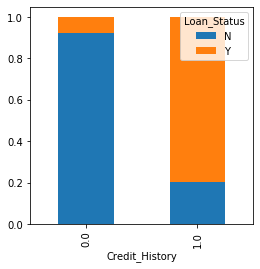

In [19]:
bi_variate_plots('Credit_History')

1. Proportion of married applicants is higher for the approved loans.
2. Distribution of applicants with 1 or 3+ dependents is similar across both the categories of Loan_Status.
3. There is nothing significant we can infer from Self_Employed vs Loan_Status plot.
4. It seems people with credit history as 1 are more likely to get their loans approved.
5. Proportion of loans getting approved in semiurban area is higher as compared to that in rural or urban areas.

# Numerical Independent Variable vs Target Variable


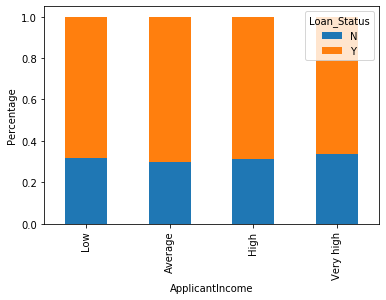

In [20]:
bins=[0,2500,4000,6000,81000] 
group=['Low','Average','High', 'Very high'] 
train['Income_bin']=pd.cut(train['ApplicantIncome'],bins,labels=group)
Income_bin=pd.crosstab(train['Income_bin'],train['Loan_Status']) 
Income_bin.div(Income_bin.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True) 
plt.xlabel('ApplicantIncome') 
P = plt.ylabel('Percentage')

In [21]:
bins=[0,2500,4000,6000,81000] 
group=['Low','Average','High', 'Very high'] 
def num_bi_variate(bins,group,new_feature,old_feature):
    train[new_feature]=pd.cut(train[old_feature],bins,labels=group)
    new_feature_bin=pd.crosstab(train[new_feature],train['Loan_Status']) 
    new_feature_bin.div(new_feature_bin.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True) 
    plt.xlabel(old_feature) 
    P = plt.ylabel('Percentage')

It can be inferred that Applicant income does not affect the chances of loan approval which contradicts our hypothesis in which we assumed that if the applicant income is high the chances of loan approval will also be high.

We will analyze the coapplicant income and loan amount variable in similar manner.

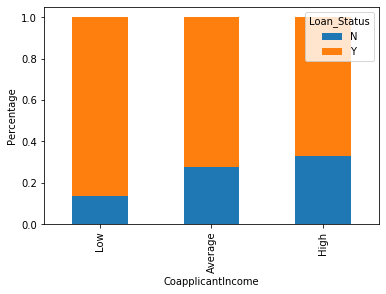

In [22]:
bins=[0,1000,3000,42000] 
group=['Low','Average','High']
train['Coapplicant_Income_bin']=pd.cut(train['CoapplicantIncome'],bins,labels=group)
Coapplicant_Income_bin=pd.crosstab(train['Coapplicant_Income_bin'],train['Loan_Status'])
Coapplicant_Income_bin.div(Coapplicant_Income_bin.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True)
plt.xlabel('CoapplicantIncome')
P = plt.ylabel('Percentage')

It shows that if coapplicant’s income is less the chances of loan approval are high. 

But this does not look right. 

The possible reason behind this may be that most of the applicants don’t have any coapplicant so the coapplicant income for such applicants is 0 and hence the loan approval is not dependent on it. 

So we can make a new variable in which we will combine the applicant’s and coapplicant’s income to visualize the combined effect of income on loan approval.

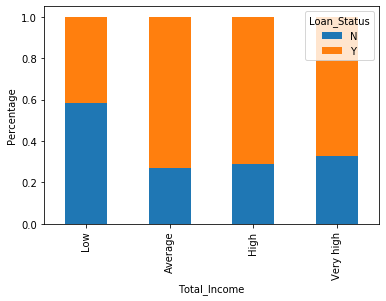

In [23]:
#Let us combine the Applicant Income and Coapplicant Income and see the combined effect of Total Income on the Loan_Status.
train['Total_Income']=train['ApplicantIncome']+train['CoapplicantIncome']
bins=[0,2500,4000,6000,81000] 
group=['Low','Average','High', 'Very high']
train['Total_Income_bin']=pd.cut(train['Total_Income'],bins,labels=group)
Total_Income_bin=pd.crosstab(train['Total_Income_bin'],train['Loan_Status']) 
Total_Income_bin.div(Total_Income_bin.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True) 
plt.xlabel('Total_Income')
P = plt.ylabel('Percentage')

We can see that Proportion of loans getting approved for applicants having low Total_Income is very less as compared to that of applicants with Average, High and Very High Income.

Let’s visualize the Loan amount variable.

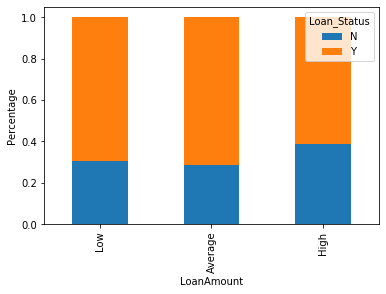

In [24]:
bins=[0,100,200,700]
group=['Low','Average','High']
train['LoanAmount_bin']=pd.cut(train['LoanAmount'],bins,labels=group)
LoanAmount_bin=pd.crosstab(train['LoanAmount_bin'],train['Loan_Status']) 
LoanAmount_bin.div(LoanAmount_bin.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True)
plt.xlabel('LoanAmount')
P = plt.ylabel('Percentage')


In [25]:
train=train.drop(['Income_bin', 'Coapplicant_Income_bin', 'LoanAmount_bin', 'Total_Income_bin', 'Total_Income'], axis=1)
train['Dependents'].replace('3+', 3,inplace=True) 
test['Dependents'].replace('3+', 3,inplace=True)
train['Loan_Status'].replace('N', 0,inplace=True)
train['Loan_Status'].replace('Y', 1,inplace=True)

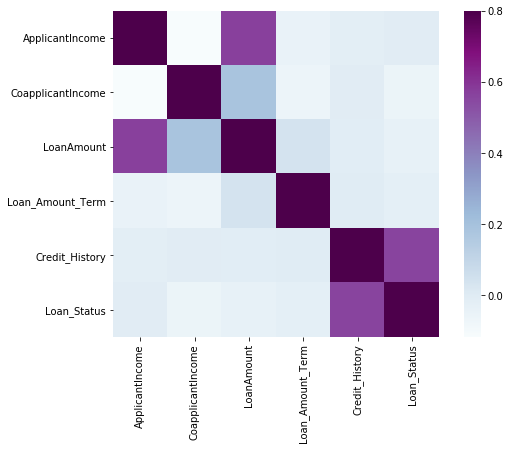

In [26]:
matrix = train.corr() 
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(matrix, vmax=.8, square=True, cmap="BuPu");


We see that the most correlated variables are (ApplicantIncome - LoanAmount) and (Credit_History - Loan_Status). LoanAmount is also correlated with CoapplicantIncome.

# Missing Values and Outliers Treatment

In [27]:
train.isnull().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

### There are missing values in Gender, Married, Dependents, Self_Employed, LoanAmount, Loan_Amount_Term and Credit_History features.

We will treat the missing values in all the features one by one.

We can consider these methods to fill the missing values:

For numerical variables: imputation using mean or median
For categorical variables: imputation using mode
There are very less missing values in Gender, Married, Dependents, Credit_History and Self_Employed features so we can fill them using the mode of the features.

In [28]:
train = fill_na(train)
test = fill_na(test)

In [29]:
train.isnull().sum()

Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

In [30]:
test.isnull().sum()


Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
dtype: int64

# Outlier Treatment


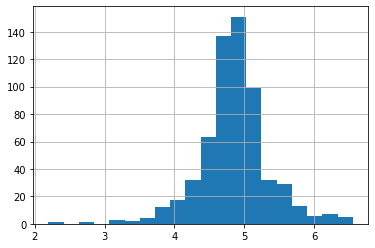

In [31]:
train['LoanAmount_log'] = np.log(train['LoanAmount']) 
train['LoanAmount_log'].hist(bins=20) 
test['LoanAmount_log'] = np.log(test['LoanAmount'])

In [32]:
train=train.drop('Loan_ID',axis=1) 
test=test.drop('Loan_ID',axis=1)

In [33]:
X = train.drop('Loan_Status',1) 
y = train.Loan_Status

In [34]:
X=pd.get_dummies(X) 
train=pd.get_dummies(train) 
test=pd.get_dummies(test)

In [35]:
x_train, x_cv, y_train, y_cv = train_test_split(X,y, test_size =0.3)


In [36]:
model = LogisticRegression() 
model.fit(x_train, y_train)
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,penalty='l2', random_state=1, solver='liblinear', tol=0.0001,verbose=0, warm_start=False)

C:\Users\skdud\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='ovr', n_jobs=1, penalty='l2', random_state=1,
                   solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [37]:
pred_cv = model.predict(x_cv)


In [38]:
accuracy_score(y_cv,pred_cv)

0.7891891891891892

In [39]:
pred_test = model.predict(test)


# Read Submission file and create our submission file using Logistic Regression

In [40]:
submission=pd.read_csv(r"C:\Users\skdud\Loan_datasets\Submission_code2\Sample_Submission.csv")

In [41]:
submission['Loan_Status']=pred_test 
submission['Loan_ID']=test_original['Loan_ID']

In [42]:
submission['Loan_Status'].replace(0, 'N',inplace=True) 
submission['Loan_Status'].replace(1, 'Y',inplace=True)

In [43]:
pd.DataFrame(submission, columns=['Loan_ID','Loan_Status']).to_csv(r'C:\Users\skdud\Loan_datasets\Submission_code2\logistic.csv',index=False)

### Logistic Regression using stratified k-folds cross validation



In [44]:
i=1 
kf = StratifiedKFold(n_splits=5,random_state=1,shuffle=True) 
for train_index,test_index in kf.split(X,y):
    print('\n{} of kfold {}'.format(i,kf.n_splits))
    xtr,xvl = X.loc[train_index],X.loc[test_index]
    ytr,yvl = y[train_index],y[test_index]
    model = LogisticRegression(random_state=1)
    model.fit(xtr, ytr)
    pred_test = model.predict(xvl)
    score = accuracy_score(yvl,pred_test)
    print('accuracy_score',score)
    i+=1 
    pred_test = model.predict(test)
    pred=model.predict_proba(xvl)[:,1]


1 of kfold 5
accuracy_score 0.8048780487804879

2 of kfold 5
accuracy_score 0.8373983739837398

3 of kfold 5
accuracy_score 0.7804878048780488

4 of kfold 5
accuracy_score 0.7886178861788617

5 of kfold 5
accuracy_score 0.7950819672131147


C:\Users\skdud\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\skdud\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-reg

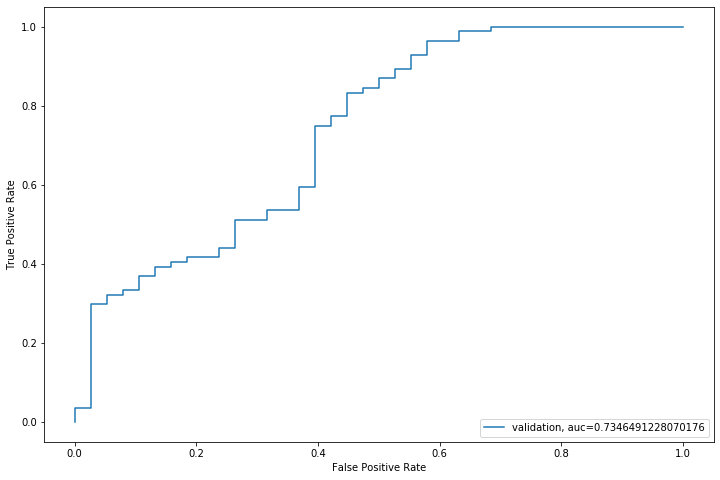

In [45]:
fpr, tpr, _ = metrics.roc_curve(yvl,  pred) 
auc = metrics.roc_auc_score(yvl, pred)
plt.figure(figsize=(12,8))
plt.plot(fpr,tpr,label="validation, auc="+str(auc)) 
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4)
plt.show()

In [46]:
submission['Loan_Status']=pred_test
submission['Loan_ID']=test_original['Loan_ID']

submission['Loan_Status'].replace(0, 'N',inplace=True) 
submission['Loan_Status'].replace(1, 'Y',inplace=True)

In [47]:
pd.DataFrame(submission, columns=['Loan_ID','Loan_Status']).to_csv(r'C:\Users\skdud\Loan_datasets\Submission_code2\logistic2.csv',index=False)


## To increase Accuracy, Lets create some new Features

In [48]:
train['Total_Income']=train['ApplicantIncome']+train['CoapplicantIncome'] 
test['Total_Income']=test['ApplicantIncome']+test['CoapplicantIncome']

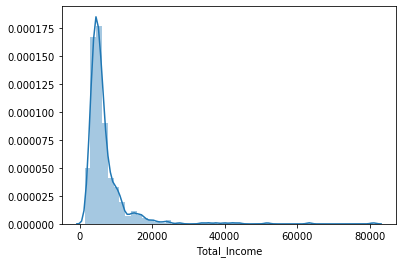

In [49]:
sns.distplot(train['Total_Income']);


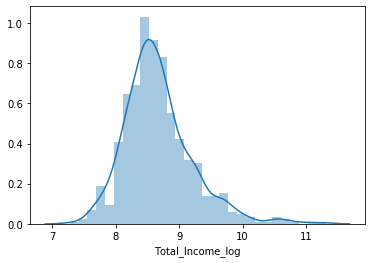

In [50]:
train['Total_Income_log'] = np.log(train['Total_Income'])
sns.distplot(train['Total_Income_log']); 
test['Total_Income_log'] = np.log(test['Total_Income'])

In [51]:
train['EMI']=train['LoanAmount']/train['Loan_Amount_Term'] 
test['EMI']=test['LoanAmount']/test['Loan_Amount_Term']

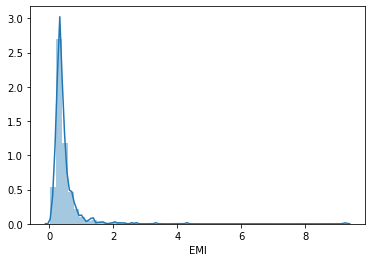

In [52]:
sns.distplot(train['EMI']);


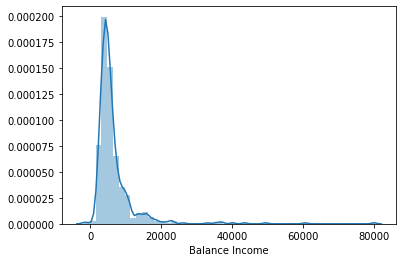

In [53]:
train['Balance Income']=train['Total_Income']-(train['EMI']*1000) # Multiply with 1000 to make the units equal test['Balance Income']=test['Total_Income']-(test['EMI']*1000)
sns.distplot(train['Balance Income']);
test['Balance Income']=test['Total_Income']-(test['EMI']*1000)

Let us now drop the variables which we used to create these new features. Reason for doing this is, the correlation between those old features and these new features will be very high and logistic regression assumes that the variables are not highly correlated. We also wants to remove the noise from the dataset, so removing correlated features will help in reducing the noise too.

In [54]:
train=train.drop(['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term'], axis=1) 
test=test.drop(['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term'], axis=1)

# Model Building : Part 2 with new features

In [55]:
X = train.drop('Loan_Status',1) 
y = train.Loan_Status 

In [56]:
i=1 
kf = StratifiedKFold(n_splits=5,random_state=1,shuffle=True) 
for train_index,test_index in kf.split(X,y):     
    print('\n{} of kfold {}'.format(i,kf.n_splits))     
    xtr,xvl = X.loc[train_index],X.loc[test_index]     
    ytr,yvl = y[train_index],y[test_index]         

    model = LogisticRegression(random_state=1)     
    model.fit(xtr, ytr)     
    pred_test = model.predict(xvl)     
    score = accuracy_score(yvl,pred_test)     
    print('accuracy_score',score)     
    i+=1 
    pred_test = model.predict(test) 
    pred=model.predict_proba(xvl)[:,1]


1 of kfold 5
accuracy_score 0.7886178861788617

2 of kfold 5
accuracy_score 0.6910569105691057

3 of kfold 5
accuracy_score 0.6666666666666666

4 of kfold 5
accuracy_score 0.7804878048780488

5 of kfold 5
accuracy_score 0.680327868852459


In [57]:
submission['Loan_Status']=pred_test            # filling Loan_Status with predictions submission['Loan_ID']=test_original['Loan_ID'] # filling Loan_ID with test Loan_ID
# replacing 0 and 1 with N and Y 
submission['Loan_Status'].replace(0, 'N',inplace=True) 
submission['Loan_Status'].replace(1, 'Y',inplace=True)
# Converting submission file to .csv format 
pd.DataFrame(submission, columns=['Loan_ID','Loan_Status']).to_csv(r'C:\Users\skdud\Loan_datasets\Submission_code2\Log2.csv',index=False)

# Decision Tree


In [58]:
from sklearn import tree
#Let’s fit the decision tree model with 5 folds of cross validation.

i=1 
kf = StratifiedKFold(n_splits=5,random_state=1,shuffle=True) 
for train_index,test_index in kf.split(X,y):     
    print('\n{} of kfold {}'.format(i,kf.n_splits))     
    xtr,xvl = X.loc[train_index],X.loc[test_index]     
    ytr,yvl = y[train_index],y[test_index]         
    model = tree.DecisionTreeClassifier(random_state=1)     
    model.fit(xtr, ytr)     
    pred_test = model.predict(xvl)     
    score = accuracy_score(yvl,pred_test)     
    print('accuracy_score',score)     
    i+=1 
    pred_test = model.predict(test)


1 of kfold 5
accuracy_score 0.7398373983739838

2 of kfold 5
accuracy_score 0.6991869918699187

3 of kfold 5
accuracy_score 0.7560975609756098

4 of kfold 5
accuracy_score 0.7073170731707317

5 of kfold 5
accuracy_score 0.6721311475409836


# Random Forest

In [59]:
i=1 
kf = StratifiedKFold(n_splits=5,random_state=1,shuffle=True) 
for train_index,test_index in kf.split(X,y):     
    print('\n{} of kfold {}'.format(i,kf.n_splits))     
    xtr,xvl = X.loc[train_index],X.loc[test_index]     
    ytr,yvl = y[train_index],y[test_index]         
    model = RandomForestClassifier(random_state=1, max_depth=10)     
    model.fit(xtr, ytr)     
    pred_test = model.predict(xvl)     
    score = accuracy_score(yvl,pred_test)     
    print('accuracy_score',score)     
    i+=1 

    pred_test = model.predict(test)


1 of kfold 5
accuracy_score 0.8292682926829268

2 of kfold 5
accuracy_score 0.8130081300813008

3 of kfold 5
accuracy_score 0.7723577235772358

4 of kfold 5
accuracy_score 0.8048780487804879

5 of kfold 5
accuracy_score 0.7540983606557377


In [60]:
from sklearn.model_selection import GridSearchCV
# Provide range for max_depth from 1 to 20 with an interval of 2 and from 1 to 200 with an interval of 20 for n_estimators 
paramgrid = {'max_depth': list(range(1, 20, 2)), 'n_estimators': list(range(1, 200, 20))}
grid_search=GridSearchCV(RandomForestClassifier(random_state=1),paramgrid)
from sklearn.model_selection import train_test_split 
x_train, x_cv, y_train, y_cv = train_test_split(X,y, test_size =0.3, random_state=1)
# Fit the grid search model 
grid_search.fit(x_train,y_train)
GridSearchCV(cv=None, error_score='raise',estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',max_depth=None, max_features='auto', max_leaf_nodes=None,min_impurity_decrease=0.0, min_impurity_split=None,            min_samples_leaf=1, min_samples_split=2,            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,oob_score=False, random_state=1, verbose=0, warm_start=False),
 iid=True, n_jobs=1,       
param_grid={'max_depth': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19], 'n_estimators': [1, 21, 41, 61, 81, 101, 121, 141, 161, 181]},       
pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',       
scoring=None, verbose=0)
# Estimating the optimized value 
grid_search.best_estimator_
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini', max_depth=3, max_features='auto', max_leaf_nodes=None,            min_impurity_decrease=0.0, min_impurity_split=None,            
min_samples_leaf=1, min_samples_split=2,            
min_weight_fraction_leaf=0.0, n_estimators=41, n_jobs=1,            
oob_score=False, random_state=1, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=3, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=41, n_jobs=1,
                       oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [61]:
i=1 
kf = StratifiedKFold(n_splits=5,random_state=1,shuffle=True) 
for train_index,test_index in kf.split(X,y):     
    print('\n{} of kfold {}'.format(i,kf.n_splits))     
    xtr,xvl = X.loc[train_index],X.loc[test_index]     
    ytr,yvl = y[train_index],y[test_index]         
    model = RandomForestClassifier(random_state=1, max_depth=3, n_estimators=41)    
    model.fit(xtr, ytr)     
    pred_test = model.predict(xvl)     
    score = accuracy_score(yvl,pred_test)     
    print('accuracy_score',score)     
    i+=1 
    pred_test = model.predict(test) 
    pred2=model.predict_proba(test)[:,1]


1 of kfold 5
accuracy_score 0.8130081300813008

2 of kfold 5
accuracy_score 0.8455284552845529

3 of kfold 5
accuracy_score 0.8048780487804879

4 of kfold 5
accuracy_score 0.7967479674796748

5 of kfold 5
accuracy_score 0.7786885245901639


In [62]:
submission['Loan_Status']=pred_test            # filling Loan_Status with predictions submission['Loan_ID']=test_original['Loan_ID'] # filling Loan_ID with test Loan_ID
# replacing 0 and 1 with N and Y 
submission['Loan_Status'].replace(0, 'N',inplace=True) 
submission['Loan_Status'].replace(1, 'Y',inplace=True)
# Converting submission file to .csv format 
pd.DataFrame(submission, columns=['Loan_ID','Loan_Status']).to_csv(r'C:\Users\skdud\Loan_datasets\Submission_code2\Random Forest.csv',index=False)

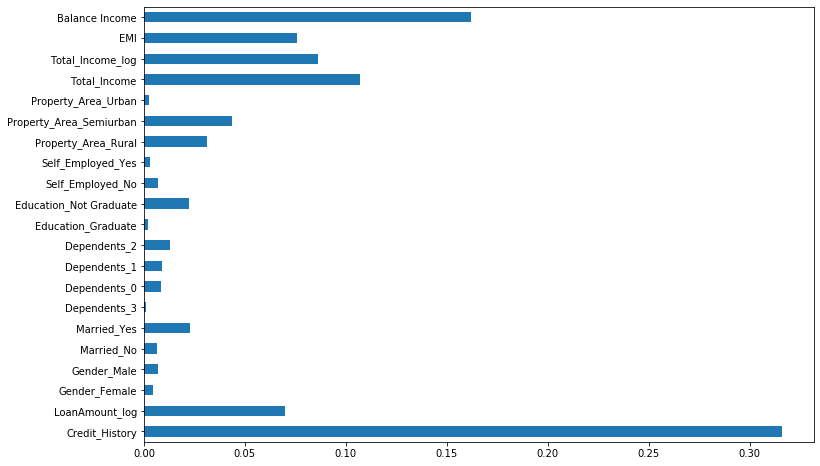

In [63]:
importances=pd.Series(model.feature_importances_, index=X.columns)
importances.plot(kind='barh', figsize=(12,8))


# XGBOOST

In [64]:
i=1 
kf = StratifiedKFold(n_splits=5,random_state=1,shuffle=True) 
for train_index,test_index in kf.split(X,y):     
    print('\n{} of kfold {}'.format(i,kf.n_splits))     
    xtr,xvl = X.loc[train_index],X.loc[test_index]     
    ytr,yvl = y[train_index],y[test_index]         
    model = XGBClassifier(n_estimators=50, max_depth=4)     
    model.fit(xtr, ytr)     
    pred_test = model.predict(xvl)     
    score = accuracy_score(yvl,pred_test)     
    print('accuracy_score',score)     
    i+=1 
    pred_test = model.predict(test) 
    pred3=model.predict_proba(test)[:,1]


1 of kfold 5
accuracy_score 0.7886178861788617

2 of kfold 5
accuracy_score 0.8292682926829268

3 of kfold 5
accuracy_score 0.7804878048780488

4 of kfold 5
accuracy_score 0.8048780487804879

5 of kfold 5
accuracy_score 0.7786885245901639


In [65]:
submission['Loan_Status']=pred_test 
submission['Loan_ID']=test_original['Loan_ID']
submission['Loan_Status'].replace(0, 'N',inplace=True) 
submission['Loan_Status'].replace(1, 'Y',inplace=True)
pd.DataFrame(submission, columns=['Loan_ID','Loan_Status']).to_csv(r'C:\Users\skdud\Loan_datasets\Submission_code2\XGBoost.csv',index=False)

In [66]:
def top_featurs_using_rf(X_train, y_train):
    sel = SelectFromModel(RandomForestClassifier(n_estimators = 100))
    sel.fit(X_train, y_train)
    sel.get_support()
    selected_feat= X_train.columns[(sel.get_support())]
    len(selected_feat)
    return selected_feat

In [67]:
top_featurs_using_rf(X,y)

Index(['Credit_History', 'LoanAmount_log', 'Total_Income', 'Total_Income_log',
       'EMI', 'Balance Income'],
      dtype='object')

# Using few features

In [104]:
high_features= X.columns
i=1 
kf = StratifiedKFold(n_splits=5,random_state=1,shuffle=True) 
for train_index,test_index in kf.split(X,y):     
    print('\n{} of kfold {}'.format(i,kf.n_splits))     
    xtr,xvl = X.loc[train_index],X.loc[test_index]     
    ytr,yvl = y[train_index],y[test_index]         
#     model = XGBClassifier(n_estimators=50, max_depth=4) 
    model = XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=4, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=42, silent=None,
                                     subsample=1, verbosity=1)
    model.fit(xtr[high_features], ytr)     
    pred_test = model.predict(xvl[high_features])     
    score = accuracy_score(yvl,pred_test)     
    print('accuracy_score',score)     
    i+=1 
    pred_test = model.predict(test[high_features]) 
    pred3=model.predict_proba(test[high_features])[:,1]


1 of kfold 5
accuracy_score 0.8048780487804879

2 of kfold 5
accuracy_score 0.7967479674796748

3 of kfold 5
accuracy_score 0.7804878048780488

4 of kfold 5
accuracy_score 0.7723577235772358

5 of kfold 5
accuracy_score 0.7868852459016393


In [105]:
submission['Loan_Status']=pred_test 
submission['Loan_ID']=test_original['Loan_ID']
submission['Loan_Status'].replace(0, 'N',inplace=True) 
submission['Loan_Status'].replace(1, 'Y',inplace=True)
pd.DataFrame(submission, columns=['Loan_ID','Loan_Status']).to_csv(r'C:\Users\skdud\Loan_datasets\Submission_code2\XGBoost_top_features.csv',index=False)

In [96]:
estimator = XGBClassifier(
    objective= 'binary:logistic',
    nthread=4,
    seed=42
)

In [97]:
parameters = {
    'max_depth': range (2, 10, 1),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05]
}

In [98]:
grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'roc_auc',
    n_jobs = 10,
    cv = 10,
    verbose=True
)

In [100]:
grid_search.fit(X, y)


Fitting 10 folds for each of 96 candidates, totalling 960 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:   24.9s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:   40.7s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:  1.3min
[Parallel(n_jobs=10)]: Done 780 tasks      | elapsed:  2.1min
[Parallel(n_jobs=10)]: Done 960 out of 960 | elapsed:  2.7min finished


GridSearchCV(cv=10, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=4, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=42, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=10,
             param_grid={'learning_rate': [0.1, 0.01, 0.05],
                         'max_depth': range(2, 10),
                         'n_estimators': range(60, 220, 40)},
        

In [106]:
X.head()

,Credit_History,LoanAmount_log,Gender_Female,Gender_Male,Married_No,Married_Yes,Dependents_3,Dependents_0,Dependents_1,Dependents_2,...,Education_Not Graduate,Self_Employed_No,Self_Employed_Yes,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban,Total_Income,Total_Income_log,EMI,Balance Income
0,1.0,4.852030,0,1,1,0,0,1,0,0,...,0,1,0,0,0,1,5849.0,8.674026,0.355556,5493.444444
1,1.0,4.852030,0,1,0,1,0,0,1,0,...,0,1,0,1,0,0,6091.0,8.714568,0.355556,5735.444444
2,1.0,4.189655,0,1,0,1,0,1,0,0,...,0,0,1,0,0,1,3000.0,8.006368,0.183333,2816.666667
3,1.0,4.787492,0,1,0,1,0,1,0,0,...,1,1,0,0,0,1,4941.0,8.505323,0.333333,4607.666667
4,1.0,4.948760,0,1,1,0,0,1,0,0,...,0,1,0,0,0,1,6000.0,8.699515,0.391667,5608.333333


[0.26102224 0.10206238 0.01419755 0.01442777 0.00988169 0.01183438
 0.01110517 0.0194356  0.01633889 0.01167191 0.01147932 0.0121625
 0.01506883 0.01602304 0.0134245  0.01874579 0.0129768  0.10838689
 0.10613001 0.10352442 0.11010032]


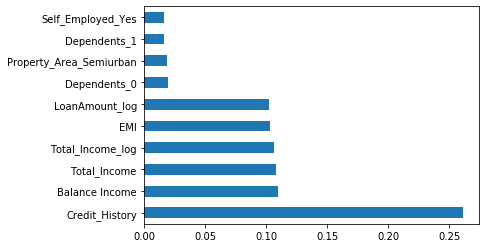

In [108]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

In [110]:
from sklearn.ensemble import GradientBoostingClassifier

model = GradientBoostingClassifier(n_estimators=100,max_depth=5)

# fit the model with the training data
model.fit(X,y)

# predict the target on the train dataset
predict_train = model.predict(X)
print('\nTarget on train data',predict_train) 

# Accuray Score on train dataset
accuracy_train = accuracy_score(y,predict_train)
print('\naccuracy_score on train dataset : ', accuracy_train)

# predict the target on the test dataset
predict_test = model.predict(X)
print('\nTarget on test data',predict_test) 

# Accuracy Score on test dataset
accuracy_test = accuracy_score(y,predict_test)
print('\naccuracy_score on test dataset : ', accuracy_test)


Target on train data [1 0 1 1 1 1 1 0 1 0 1 1 1 0 1 1 1 0 0 1 0 1 0 0 0 1 1 1 0 1 0 0 0 1 0 1 0
 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 1 1 0 1 1 1 0
 1 0 0 0 0 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1
 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 0 1 0 0 0 1 1 1 1 1 1 1
 0 1 0 1 0 0 1 1 1 1 1 1 1 0 0 1 1 1 0 1 0 1 1 1 0 1 0 1 1 0 1 0 0 0 1 0 1
 1 0 1 1 1 1 0 0 1 1 0 1 1 1 0 1 1 0 1 1 1 1 1 1 0 0 0 1 1 1 1 0 1 0 1 0 1
 1 1 1 0 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 0 1 1 1 1 0 0 1 1 0 1 0 0 0
 0 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 0 1 1 1 1 0 1 0 1 1
 1 1 0 0 0 1 1 1 1 0 1 0 0 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 0 1 1 0 1 1 1 1
 1 1 1 1 1 0 1 0 0 1 1 1 1 0 1 1 1 1 0 1 0 1 1 1 0 0 1 0 1 1 1 1 0 0 0 1 0
 1 1 1 0 1 1 1 1 0 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 0 1 1 0 0 0 1 1 0 1 1
 1 0 0 0 1 0 1 0 1 0 0 1 1 1 0 1 0 1 1 0 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1
 1 1 1 0 0 0 0 1 0 1 1 1 1 0 1 0 1 1 1 1 0 1 0 1 1 0 1 0 1 1 1 1 1 0 1 0 1
 1 

In [111]:
pred_test = model.predict(test) 

In [113]:
submission['Loan_Status']=pred_test 
submission['Loan_ID']=test_original['Loan_ID']
submission['Loan_Status'].replace(0, 'N',inplace=True) 
submission['Loan_Status'].replace(1, 'Y',inplace=True)
pd.DataFrame(submission, columns=['Loan_ID','Loan_Status']).to_csv(r'C:\Users\skdud\Loan_datasets\Submission_code2\GBS.csv',index=False)

In [114]:
i=1 
kf = StratifiedKFold(n_splits=5,random_state=1,shuffle=True) 
for train_index,test_index in kf.split(X,y):     
    print('\n{} of kfold {}'.format(i,kf.n_splits))     
    xtr,xvl = X.loc[train_index],X.loc[test_index]     
    ytr,yvl = y[train_index],y[test_index]         
    model = GradientBoostingClassifier(n_estimators=100,max_depth=5)     
    model.fit(xtr, ytr)     
    pred_test = model.predict(xvl)     
    score = accuracy_score(yvl,pred_test)     
    print('accuracy_score',score)     
    i+=1 
    pred_test = model.predict(test) 
    pred3=model.predict_proba(test)[:,1]


1 of kfold 5
accuracy_score 0.7886178861788617

2 of kfold 5
accuracy_score 0.7642276422764228

3 of kfold 5
accuracy_score 0.8048780487804879

4 of kfold 5
accuracy_score 0.7642276422764228

5 of kfold 5
accuracy_score 0.7704918032786885
